# **2. Entrenamiento** **del** **modelo** **NER** **(parte 1)**

En este módulo se lleva a cabo una primera fase de entrenamiento del modelo NER para detección de ingredientes en textos de receta. Con los resultados obtenidos de este primer entrenamiento, trataremos en los siguientes módulos de refinar de nuevo los datos de entrada para obtener un modelo más robusto.



In [ ]:
!pip install -q transformers datasets seqeval accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # autoriza en el popup

Mounted at /content/drive


Descarga y preparación de los datos: separamos el dataset de entrada en train, validation y test. Para dar mayor consitencia y robustez en el entrenamiento, normalizamos las etiquetas antes de tokenizar el dataset, eliminando espacios internos y acentos. Para ello utilizamos las funciones ***strip_accents*** y ***reg_label***.  

In [ ]:
import json
from pathlib import Path
# Leerlo de vuelta para chequear que todo esta bien
contenido = Path("train_data.json").read_text(encoding="utf-8")
data = json.loads(contenido)

In [ ]:
from sklearn.model_selection import train_test_split

train, rest = train_test_split(data, test_size=0.2, random_state=42)
val, test = train_test_split(rest, test_size=0.5, random_state=42)

In [ ]:
#Regularizamos las etiquetas antes de tokenizar el corpus de entrenamiento. Definimos una lista con las etiquetas ya regularizadas
import unicodedata, re

def strip_accents(s:str)->str:
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

def reg_label(name:str)->str:
    s = strip_accents(name).upper().strip()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^A-Z0-9_]", "", s)
    return s

label_set = sorted({ reg_label(ent["label"]) for ex in train for ent in ex["entities"] })
print(label_set)

['ACEITE', 'ACEITE_DE_OLIVA', 'AGUA', 'AJO', 'ARROZ', 'ATUN', 'AZUCAR', 'BACALAO', 'CALABACIN', 'CALDO_DE_PESCADO', 'CALDO_DE_POLLO', 'CEBOLLA', 'CEBOLLETA', 'GARBANZO', 'HARINA', 'HUEVO', 'LECHE', 'LIMON', 'MANTEQUILLA', 'MERLUZA', 'NATA', 'PAN', 'PASTA', 'PATATA', 'PEREJIL', 'PIMENTON', 'PIMIENTA', 'PIMIENTO', 'POLLO', 'PUERRO', 'QUESO', 'SAL', 'SALMON', 'TOMATE', 'VINAGRE', 'VINO_BLANCO', 'ZANAHORIA']


A partir de las etiquetas previamente regularizadas, se procede a generar las etiquetas en formato BIO. Además, se construyen dos diccionarios de mapeo, uno de codificación de etiqueta-id y otro de decodificación id-etiqueta.

In [ ]:
#A partir de las etiquetas regularizadas definimos las etiquetas BIO, así como los diccionarios que relacionan los BIO con un id numerico y vicerversa
bio_labels = ["O"] + [f"B-{l}" for l in label_set] + [f"I-{l}" for l in label_set]
label2id = {lab:i for i, lab in enumerate(bio_labels)}
id2label = {i:lab for lab,i in label2id.items()}

Tokenizamos nuestro dataset ajustandolo al modelo "*dccuchile/bert-base-spanish-wwm-cased*" que utilizamos como base para entrenar nuestro modelo NER.

In [ ]:
from transformers import AutoTokenizer
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Con la función ***encode_and_align*** se tokeniza el texto, se alinean las entidades anotadas con los tokens y se codifican las etiquetas en formato BIO para que el dataset quede listo para el entrenamiento del modelo.

In [ ]:
def encode_and_align(example):
    text = example["text"]
    ents = example["entities"]  # lista de dicts con start,end,label (original)

    # Regularizar labels de entidades para que coincidan con los de la lista label_set
    spans = []
    for e in ents:
        s, e2 = int(e["start"]), int(e["end"])
        if 0 <= s < e2 <= len(text):
            lab = reg_label(e["label"])
            spans.append((s, e2, lab))  # (start, end, LAB)

    # Tokenizar con offsets
    enc = tokenizer(text, return_offsets_mapping=True, truncation=True, max_length=512)
    offsets = enc["offset_mapping"]

    # Inicializar etiquetas a -100 (se ignoran en la pérdida)
    labels = [-100] * len(offsets)

    # Para cada token "real", asignar B/I si cae dentro de algún span
    for i, (start, end) in enumerate(offsets):
        if start == end:   # tokens especiales
            continue
        # encontrar entidades que contengan completamente el token (estricto)
        tag = None
        for s, e2, lab in spans:
            if start >= s and end <= e2:
                # comienzo exacto del span -> B, si no -> I
                tag = f"B-{lab}" if start == s else f"I-{lab}"
                break
        if tag is None:
            tag = "O"
        labels[i] = label2id[tag]

    enc["labels"] = labels
    return enc

In [ ]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_list(train),
    "validation": Dataset.from_list(val),
    "test": Dataset.from_list(test),
})

encoded = ds.map(encode_and_align, remove_columns=ds["train"].column_names, desc="Tokenizando y alineando")

Tokenizando y alineando:   0%|          | 0/883 [00:00<?, ? examples/s]

Tokenizando y alineando:   0%|          | 0/110 [00:00<?, ? examples/s]

Tokenizando y alineando:   0%|          | 0/111 [00:00<?, ? examples/s]

Importamos las librerías para entrenar el modelo NER. Utilizaremos módulos de  ***transformers*** para la carga del modelo, configuración de los parámetros de entrenamiento y gestión del proceso de fine-tuning, y la librería ***seqeval*** para el cálculo de métricas del etiquetado NER.

In [ ]:
import torch
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from seqeval.metrics import classification_report

Definimos la función ***align_predictions***, quetransforma las predicciones y etiquetas reales  en listas alineadas, excluyendo los tokens ignorados (etiquetados como -100), para facilitar su posterior evaluación con métricas tipo seqeval.

In [ ]:
import numpy as np

def align_predictions(predictions, label_ids):
  # Obtenemos prediccionnes
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  #  en cada batch de datos
  for batch_idx in range(batch_size):
    # Generamos muestras de true_values y predicciones en formato seq-eval
    example_labels, example_preds = [], []
    # Para cada documento
    for seq_idx in range(seq_len):
      # Ignoramos etiquetas que sean -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(id2label[int(label_ids[batch_idx][seq_idx])])
        example_preds.append(id2label[int(preds[batch_idx][seq_idx])])

    labels_list.append(example_labels)
    preds_list.append(example_preds)

  return preds_list, labels_list

Definimos la función ***compute_metrics*** que calcula el F1-score por clase, evaluando el rendimiento del modelo sobre cada entidad correspondiente a los ingredientes especificados en el conjunto de etiquetas.

In [ ]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true,y_pred)}

Entrenamiento del modelo: definimos la función ***set_seed*** para definir semilla de replicabilidad. Se configura el modelo y se entrena.

In [ ]:
# Definimos algunos parámetros de configuracion
num_epochs = 5
batch_size = 16
logging_steps = 10
model_name_save = f"output-model"

In [ ]:
import random

def set_seed(seed=52):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(52)

In [ ]:
training_args = TrainingArguments(
    output_dir = model_name_save, log_level = "error",
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    save_steps=50,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=10,
    logging_strategy="steps",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    seed=52,
    full_determinism=True
)

In [ ]:
from transformers import AutoConfig
model_config = AutoConfig.from_pretrained(model_name,
                                            num_labels = len(label2id),
                                            id2label = id2label,
                                            label2id=label2id)

In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer,return_tensors="pt")

In [ ]:
def model_init():
    return AutoModelForTokenClassification.from_pretrained(
    model_name, config=model_config
)
model = AutoModelForTokenClassification.from_pretrained(model_name, config=model_config)

In [ ]:
trainer = Trainer(model = model, # model
                  args = training_args, # training_args
                  data_collator = data_collator, # data_collator
                  compute_metrics = compute_metrics, # compute_metrics
                  train_dataset = encoded["train"],
                  eval_dataset = encoded["validation"],
                  tokenizer = tokenizer)

/tmp/ipython-input-3500203268.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model = model, # model


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,F1
10,1.274800,0.459021,0.000000
20,0.406700,0.424119,0.000000
30,0.341000,0.293811,0.000000
40,0.272300,0.262912,0.183085
50,0.223700,0.213899,0.312243
60,0.181100,0.169851,0.523524
70,0.146600,0.131777,0.671164
80,0.114900,0.105831,0.735245
90,0.091200,0.092771,0.788779
100,0.080000,0.084536,0.794702


TrainOutput(global_step=140, training_loss=0.24229760936328343, metrics={'train_runtime': 353.5962, 'train_samples_per_second': 12.486, 'train_steps_per_second': 0.396, 'total_flos': 718576627098600.0, 'train_loss': 0.24229760936328343, 'epoch': 5.0})

Con el modelo actualizado, generamos una gráfica comparativa de la evolución de la pérdida (loss) en entrenamiento y validación a lo largo de  las etapas de entrenamiento para estudiar el sobreajuste del modelo.

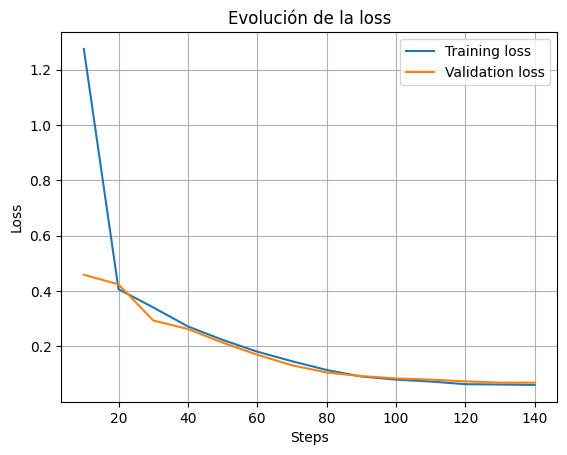

In [ ]:
# Mostrar curva de pérdida usando los logs del trainer
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(trainer.state.log_history)
# Separar las filas de entrenamiento y evaluación
train_rows = df[df["loss"].notna()].copy()
eval_rows = df[df["eval_loss"].notna()].copy()

# Fusionar por columna 'step'
combined = pd.merge(train_rows, eval_rows, on="step", suffixes=("_train", "_eval"))


# Filtramos solo los pasos con loss y eval_loss
loss_log = combined[["step", "loss_train", "eval_loss_eval"]].dropna()

plt.plot(loss_log["step"], loss_log["loss_train"], label="Training loss")
plt.plot(loss_log["step"], loss_log["eval_loss_eval"], label="Validation loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Evolución de la loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
trainer.save_model("/content/drive/MyDrive/TFM/ner_model")  # guarda pesos + config.json
tokenizer.save_pretrained("/content/drive/MyDrive/TFM/ner_model")

('/content/drive/MyDrive/TFM/ner_model/tokenizer_config.json',
 '/content/drive/MyDrive/TFM/ner_model/special_tokens_map.json',
 '/content/drive/MyDrive/TFM/ner_model/vocab.txt',
 '/content/drive/MyDrive/TFM/ner_model/added_tokens.json',
 '/content/drive/MyDrive/TFM/ner_model/tokenizer.json')

Evaluación del modelo:

In [ ]:
path = "/content/drive/MyDrive/TFM/ner_model"
tokenizer = AutoTokenizer.from_pretrained(path)
model     = AutoModelForTokenClassification.from_pretrained(path)

In [ ]:
test_metrics = trainer.evaluate(encoded["test"])
print(test_metrics)

{'eval_loss': 0.07974723726511002, 'eval_f1': 0.808545603944125, 'eval_runtime': 2.3206, 'eval_samples_per_second': 47.832, 'eval_steps_per_second': 3.016, 'epoch': 5.0}


Para calcular las métricas de evaluación por clase, obtenemos primero las predicciones del modelo y las alineamos con las etiquetas reales mediante la función ***align_predictions***. Luego, generamos un reporte detallado por clase en formato BIO usando ***seqeval***, y se calculan las métricas globales de precisión, recall y F1-score para cuantificar la calidad del modelo.

In [ ]:
# Reporte detallado por clase (BIO) con seqeval
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

# Predicciones en test
pred = trainer.predict(encoded["test"])

# Retorno de (y_pred, y_true)
y_pred, y_true = align_predictions(pred.predictions, pred.label_ids)

# Reporte por clase (BIO)
print(classification_report(y_true, y_pred, digits=3))

# Métricas globales
print({
    "precision": precision_score(y_true, y_pred),
    "recall":    recall_score(y_true, y_pred),
    "f1":        f1_score(y_true, y_pred),
})

                  precision    recall  f1-score   support

          ACEITE      0.000     0.000     0.000         7
 ACEITE_DE_OLIVA      0.939     1.000     0.969        31
            AGUA      0.588     0.769     0.667        26
             AJO      0.830     1.000     0.907        44
           ARROZ      0.867     0.963     0.912        27
            ATUN      0.000     0.000     0.000         3
          AZUCAR      1.000     1.000     1.000        13
         BACALAO      0.929     1.000     0.963        13
       CALABACIN      0.000     0.000     0.000         3
CALDO_DE_PESCADO      0.750     1.000     0.857         3
  CALDO_DE_POLLO      0.889     1.000     0.941         8
         CEBOLLA      0.722     1.000     0.839        39
       CEBOLLETA      0.000     0.000     0.000         9
        GARBANZO      0.786     0.917     0.846        12
          HARINA      0.895     1.000     0.944        17
           HUEVO      0.850     1.000     0.919        17
           LE

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
